In [242]:
import numpy as np
import matplotlib.pyplot as plt

In [243]:

HX_length = 100
distance_to_blocks = 24.5
throttle_length = 32.64
block_length = 84
block_space = 21
vertical_block_length = 14.3

receiver_length = HX_length  # Length of the receiver
receiver_position = (0.0,receiver_length/2)

panel_length = throttle_length  # Length of the throttle panelottle_length  # Length of the throttle panelottle_length  # Length of the throttle panelottle_length  # Length of the throttle panel
panel_position = (distance_to_blocks,(receiver_length/2 - block_space/2)+(panel_length/2))  # X-position of the blocking panel (center of the panel)
 #Between 0.1 and 89.9 where 90 is fully open
panel_angle_range = np.arange(0.5, 90, 5)
#panel_angle_range = [89.9, 45, 0.01]
print(panel_position[1] - (panel_length/2))
print(panel_position[1] + (panel_length/2))



#emitter_position = 10.0  # Position of the emitter surface (emitter)
emitter_surface_length = block_length  # Length of the emitter surface (emitter)
emitter_position = (panel_position[0]+ emitter_surface_length/2,receiver_length/2 - block_space/2)  # Position of the receiver

emitter_start_x = emitter_position[0] - emitter_surface_length/2
emitter_start_y = emitter_position[1]
emitter_end_x = emitter_position[0] + emitter_surface_length/2
emitter_end_y = emitter_position[1]
print( emitter_start_y)


barrier_length = emitter_surface_length
barrier_position = (emitter_position[0], emitter_position[1] + block_space)


vertical_emitter_surface_length = vertical_block_length
vertical_emitter_position = (distance_to_blocks, barrier_position[1] + vertical_emitter_surface_length/2)
print(vertical_emitter_position)

# Simulation parameters


39.5
40.5
39.5
(24.5, 67.65)


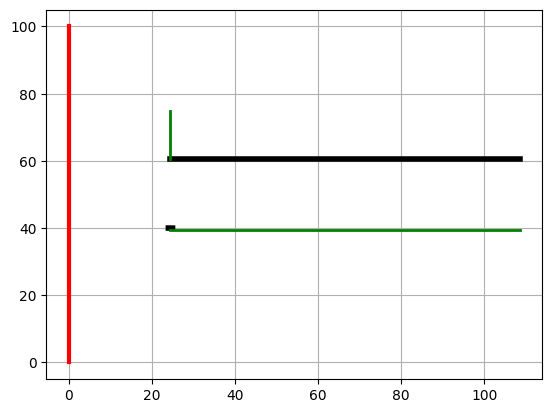

In [244]:
#Graph Geometry
panel_angle = 89
def plot_component(length, midpoint, angle_deg, component_type='default'):
    # Define color and thickness based on component type
    if component_type == 'emitter':
        color = 'green'
        thickness = 2
    elif component_type == 'panel' or component_type =='barrier':
        color = 'black'
        thickness = 4
    elif component_type == 'receiver':
        color = 'red'
        thickness = 3
    else:
        # Default style
        color = 'black'
        thickness = 1

    # Convert angle from degrees to radians
    angle_rad = np.radians(angle_deg)
    
    # Calculate the start and end points of the line
    dx = (length / 2) * np.cos(angle_rad)
    dy = (length / 2) * np.sin(angle_rad)
    
    x_start = midpoint[0] - dx
    x_end = midpoint[0] + dx
    y_start = midpoint[1] - dy
    y_end = midpoint[1] + dy
    
    # Plot the line with the given color and thickness
    plt.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=thickness)

plot_component(receiver_length, receiver_position, 90, component_type='receiver')
plot_component(panel_length, panel_position, panel_angle+90, component_type='panel')
plot_component(emitter_surface_length, emitter_position, 0, component_type='emitter')
plot_component(barrier_length, barrier_position, 0, component_type='barrier')
plot_component(vertical_emitter_surface_length, vertical_emitter_position, 90, component_type='emitter')
plt.grid()
plt.show()

In [245]:
def generate_old__particle():
    position = np.random.uniform(0, emitter_surface_length)  # Random position on the emitte
    rand_cos = np.random.uniform(0, 1) # Distribution has to follow lambers law for emitter surfaces
    angle = np.arccos(rand_cos)-np.pi/2
    return position, angle

def generate_particle_path(midpoint, length):
    x_position = np.random.uniform(midpoint[0]-length/2, midpoint[0]+length/2)  # Random position on the emitte
    rand_cos = np.random.uniform(-1, 1) # Distribution has to follow lambers law for emitter surfaces
    angle = np.arccos(rand_cos)
    angle_deg = np.rad2deg(angle)
    #print(angle)
    slope = np.tan(angle)  # Slope of the trajectory (dy/dx)
    y_inter = midpoint[1] - slope *x_position
    return slope, y_inter

def generate_vertical_particle_path(midpoint, length):
    y_position = np.random.uniform(midpoint[1]-length/2, midpoint[1]+length/2)  # Random position on the emitte
    rand_cos = np.random.uniform(-1, 1) # Distribution has to follow lambers law for emitter surfaces
    angle = np.arccos(rand_cos)
    
    angle = angle + np.pi/2 # Angle towards to the left
    angle_deg = np.rad2deg(angle)
    slope = np.tan(angle)  # Slope of the trajectory (dy/dx)
    #print(slope)
    y_inter = y_position - slope *midpoint[0]
    #print(slope)
    return slope, y_inter

# Check if the particle hits a vertical panel
# def hits_vertical_panel(particle_slope, particle_intercept):
#     global counter
#     y_at_panel = particle_slope * (panel_position[0]) + particle_intercept  # y-position when x = panel_position
#     if (panel_position[1] + panel_length/2) > (y_at_panel) > (panel_position[1] - panel_length/2) :
#          # Particle hits the panel
#         return True
#     return False
def hits_horizontal_panel(particle_slope, particle_intercept):
    global counter
    x_at_barrier = (barrier_position[1] - particle_intercept ) /particle_slope
    if (emitter_start_x) <= (x_at_barrier) <= (emitter_end_x) :
        counter += 1
        return True
    return False

def hits_slanted_panel(particle_slope, particle_intercept, panel_angle):
    global counter
    panel_angle = np.radians(panel_angle+90)
    panel_start_x = panel_position[0] - (panel_length/2) * np.cos(panel_angle)
    panel_start_y = panel_position[1] - (panel_length/2) * np.sin(panel_angle)
    panel_end_x = panel_position[0] + (panel_length/2) * np.cos(panel_angle)
    panel_end_y = panel_position[1] + (panel_length/2) * np.sin(panel_angle)

    
    panel_slope = np.tan(panel_angle)
    panel_intercept = panel_start_y - panel_slope * panel_start_x
     
    # Solve for x_intersection:
    if particle_slope != panel_slope:  # Ensure the slopes aren't equal (no intersection)
        
        x_intersection = (panel_intercept - particle_intercept) / (particle_slope - panel_slope)
        y_intersection = particle_slope * (x_intersection) + particle_intercept
        y_intersection2 = panel_slope * (x_intersection) + panel_intercept
        if np.abs(y_intersection - y_intersection2) < 0.0001:
            pass
        # Check if the intersection point is within the bounds of the slanted panel
        if panel_start_x <= x_intersection <= panel_end_x or panel_start_y <= y_intersection <= panel_end_y:
            
            return x_intersection  # The particle hits the panel
        
    return False  # No hit

def hits_receiver(particle_slope, particle_intercept):

    y_at_receiver = particle_slope * (receiver_position[0]) + particle_intercept  # y-position at receiver x = 1.0
    if 0 <= y_at_receiver <= receiver_length:
        return particle_slope, y_at_receiver  # The particle hits the receiver
    return False

def view_factor_parallel_plates(w_i, w_j, L):
    # Calculate the normalized widths
    W_i = w_i / L
    W_j = w_j / L
    F_ij = (np.sqrt((W_i + W_j)**2 + 4) - np.sqrt((W_i - W_j)**2 + 4)) / (2 * W_i)
    return F_ij
def view_factor_perpendicular_plates(emmitor, panel):
    F_ij = (1 + (panel/emmitor) - ( 1 + (panel/emmitor)**2 )**0.5)/2
    return F_ij


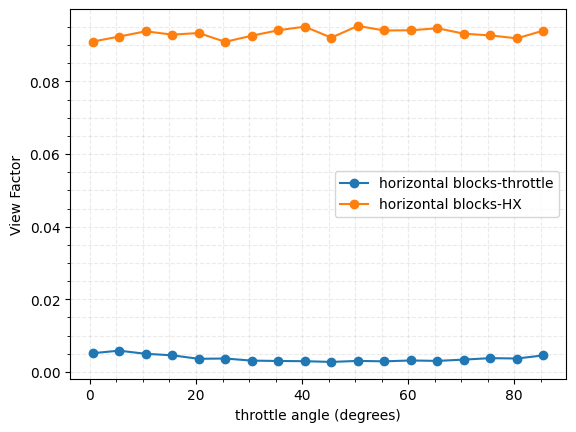

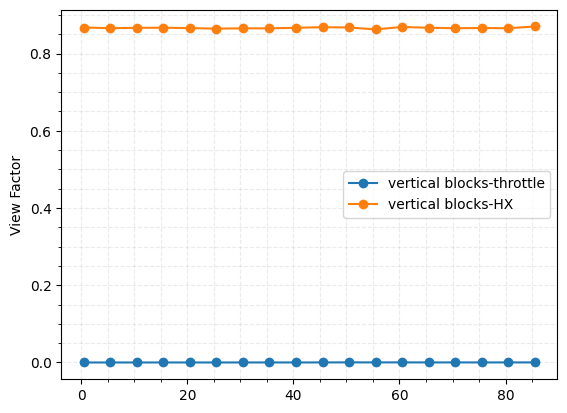

--------------------------------------------------------
Estimated horizontal blocks-throttle VF: 0.00456
Estimated horizontal blocks-HX Box VF: 0.09402
Estimated vertical blocks-throttle VF: 0.00014
Estimated vertical blocks-HX Box VF: 0.87
--------------------------------------------------------

Max horizontal blocks-throttle VF: 0.005916951368634127
Max vertical blocks-HX Box VF: 0.8965410796591845
mean slope for horizontal emittor is: 1.0864274068495159
mean slope for vertical emittor is: 0.0009063876348848823


In [246]:
num_particles = 50000
counter = 0
list= []
list2 = []
slanted_panel_vf_range = []
slanted_receiver_vf_range = []
vertical_panel_vf_range = []
vertical_receiver_vf_range = []

for panel_angle in panel_angle_range:
    # Simulation loop
    vertical_receiver_hits = 0
    vertical_panel_hits = 0
    slanted_receiver_hits = 0
    slanted_panel_hits = 0


    for _ in range(num_particles):
        particle_slope1, particle_intercept1 = generate_particle_path(emitter_position, emitter_surface_length)  # Generate random particle emission
        list.append(particle_slope1)
        particle_slope2, particle_intercept2 = generate_vertical_particle_path(vertical_emitter_position, vertical_emitter_surface_length)  # Generate random particle emission
        list2.append(particle_slope2)
        if not hits_horizontal_panel(particle_slope1, particle_intercept1):
            if particle_slope1 < 0: #Don't include ones that are pointing away
                # # Check if it hits horizontal the panel
                # if hits_vertical_panel(particle_slope1, particle_intercept1):  # Check if it hits vertical the panel
                #     vertical_panel_hits += 1
                # else:
                #     if hits_receiver(particle_slope1, particle_intercept1):  # Check if it hits the receiver
            #         vertical_receiver_hits     += 1
                
                if hits_slanted_panel(particle_slope1, particle_intercept1, panel_angle):  # Check if it hits the slanted panel
                    slanted_panel_hits += 1
                else:
                    hit = hits_receiver(particle_slope1, particle_intercept1)
                    if hit is not False:  # Check if it hits the receiver
                        #list.append(hit)  # Store the particle path for later analysis
                        
                        slanted_receiver_hits += 1
        if hits_slanted_panel(particle_slope2, particle_intercept2, panel_angle): #< vertical_emitter_position[0]:
            vertical_panel_hits += 1
        else:
            hit2 = hits_receiver(particle_slope2, particle_intercept2)
            if hit2 is not False:  # Check if it hits the receiver
                vertical_receiver_hits += 1

    # Estimate view factor
    vertical_panel_vf = vertical_panel_hits / num_particles
    vertical_receiver_vf = vertical_receiver_hits / num_particles
    vertical_panel_vf_range.append(vertical_panel_vf)
    vertical_receiver_vf_range.append(vertical_receiver_vf)

    slanted_panel_vf = slanted_panel_hits / num_particles
    slanted_receiver_vf = slanted_receiver_hits / num_particles
    slanted_panel_vf_range.append(slanted_panel_vf)
    slanted_receiver_vf_range.append(slanted_receiver_vf)

analytical_vertical_panel_vf = view_factor_perpendicular_plates(emitter_surface_length, panel_length)
analytical_vertical_receiver_vf = view_factor_parallel_plates(vertical_emitter_surface_length, receiver_length, np.abs(receiver_position[0]-panel_position[0]))

#Plot how the view factors change for the depending on fi the throttles are opening inside or outside
plt.plot(panel_angle_range, slanted_panel_vf_range, label='horizontal blocks-throttle', marker='o' )
plt.plot(panel_angle_range, slanted_receiver_vf_range, label='horizontal blocks-HX', marker='o')
plt.xlabel('throttle angle (degrees)')

plt.ylabel('View Factor')
plt.xticks(np.arange(0, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()

#plt.plot(panel_angle_range, vertical_panel_vf_range, label='blocks2-throttle', marker='o' )
plt.plot(panel_angle_range, vertical_panel_vf_range, label='vertical blocks-throttle', marker='o')
plt.plot(panel_angle_range, vertical_receiver_vf_range, label='vertical blocks-HX', marker='o')
plt.ylabel('View Factor')
plt.xticks(np.arange(0, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()

plt.show()
#print(counter)
print("--------------------------------------------------------")
print("Estimated horizontal blocks-throttle VF:", slanted_panel_vf)
print("Estimated horizontal blocks-HX Box VF:", slanted_receiver_vf)
print("Estimated vertical blocks-throttle VF:", vertical_panel_vf)
print("Estimated vertical blocks-HX Box VF:", vertical_receiver_vf)
print("--------------------------------------------------------\n")
print("Max horizontal blocks-throttle VF:", analytical_vertical_panel_vf)
print("Max vertical blocks-HX Box VF:", analytical_vertical_receiver_vf)
print("mean slope for horizontal emittor is:", np.mean(list))
print("mean slope for vertical emittor is:", np.mean(list2))

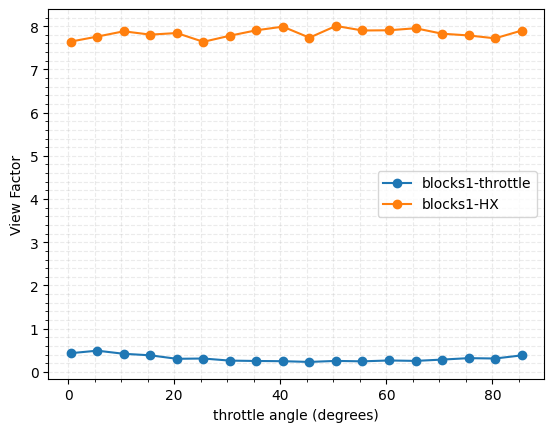

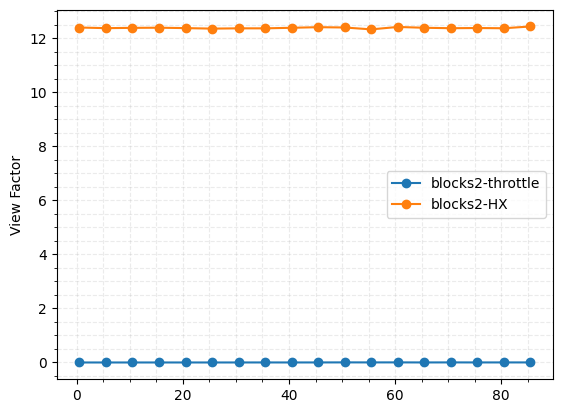

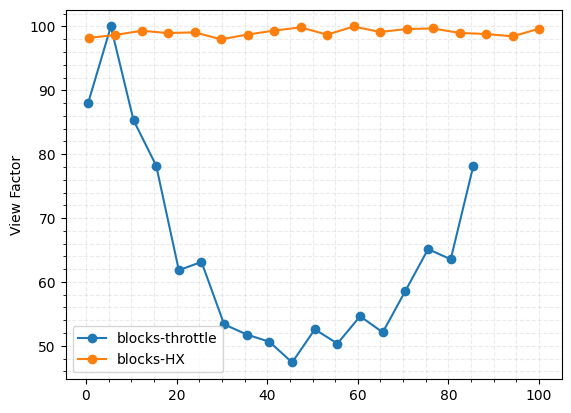

In [247]:

slanted_panel_vf_range = np.array(slanted_panel_vf_range)*emitter_surface_length
slanted_receiver_vf_range = np.array(slanted_receiver_vf_range)*emitter_surface_length
vertical_panel_vf_range = np.array(vertical_panel_vf_range)*vertical_emitter_surface_length
vertical_receiver_vf_range = np.array(vertical_receiver_vf_range)*vertical_emitter_surface_length


panel_vf_range = slanted_panel_vf_range + vertical_panel_vf_range
receiver_vf_range = slanted_receiver_vf_range + vertical_receiver_vf_range

panel_vf_range = panel_vf_range/np.max(panel_vf_range)*100
receiver_vf_range = receiver_vf_range/np.max(receiver_vf_range)*100
panel_percent = panel_angle_range/np.max(panel_angle_range)*100


#Plot how the view factors change for the depending on fi the throttles are opening inside or outside
plt.plot(panel_angle_range, slanted_panel_vf_range, label='blocks1-throttle', marker='o' )
plt.plot(panel_angle_range, slanted_receiver_vf_range, label='blocks1-HX', marker='o')
plt.xlabel('throttle angle (degrees)')

plt.ylabel('View Factor')
plt.xticks(np.arange(0, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()

#plt.plot(panel_angle_range, vertical_panel_vf_range, label='blocks2-throttle', marker='o' )
plt.plot(panel_angle_range, vertical_panel_vf_range, label='blocks2-throttle', marker='o')
plt.plot(panel_angle_range, vertical_receiver_vf_range, label='blocks2-HX', marker='o')
plt.ylabel('View Factor')
plt.xticks(np.arange(0, 90, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()

#plt.plot(panel_angle_range, vertical_panel_vf_range, label='blocks2-throttle', marker='o' )
plt.plot(panel_angle_range, panel_vf_range, label='blocks-throttle', marker='o')
plt.plot(panel_percent, receiver_vf_range, label='blocks-HX', marker='o')
plt.ylabel('View Factor')
plt.xticks(np.arange(0, 120, 20))
plt.minorticks_on()
plt.grid(which='both', linestyle='--', alpha=0.25)
plt.legend()
plt.show()


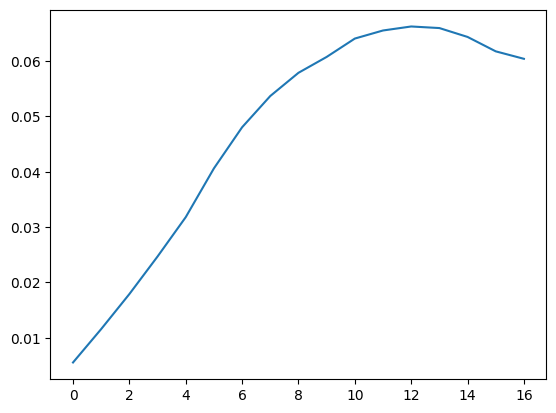

In [248]:
#Old perspective on throttle design
try1 = [0.087098, 0.038148, 0.044924, 0.05177, 0.056592, 0.059796, 0.060786, 0.061106, 0.058964, 0.056922, 0.0533, 0.047908, 0.040606, 0.031796, 0.024684, 0.017894, 0.011566, 0.005522, 0.0, 8e-06, 8.2e-05, 0.000176, 0.000478, 0.000878, 0.001694, 0.002474, 0.003478, 0.005064, 0.006638, 0.008646, 0.010878, 0.013968, 0.016916, 0.020076, 0.024014, 0.027576, 0.0]
try1 = try1[::-1]

try2 = [0.055796, 0.036784, 0.042878, 0.047818, 0.050978, 0.052452, 0.05373, 0.053238, 0.051356, 0.0493, 0.04595, 0.040982, 0.035212, 0.028112, 0.020592, 0.01418, 0.008836, 0.004044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8e-06, 0.000136, 0.000394, 0.000966, 0.001794, 0.002972, 0.004752, 0.006466, 0.009384, 0.0126, 0.016842, 0.022268, 0.00126]
try3 = np.array(try1) + np.array(try2)
plt.plot(try3[19:-1])
